In [1]:
# GET DATA

from obspy import UTCDateTime
from seiscamp.util import *

station = "FRS5"
channel = "HHZ"
starttime = UTCDateTime("20200301")
num_days = 31
fs = 50.0
trace1 = get_stream_days(station=station, channel=channel, first_day=starttime, num_days=num_days, fs=fs)

print(trace1)
tvec = trace1.times("matplotlib")

4E.FRS5..HHZ | 2020-03-01T00:00:00.000000Z - 2020-03-31T23:59:59.980000Z | 50.0 Hz, 133920000 samples


In [2]:
# IMPORT MATRIX PROFILE

from obspy import read, UTCDateTime, Stream
import os
import numpy as np
import sys
import time
from glob import glob
from seiscamp.MPLib import *
from seiscamp.GraphLib import *
from seiscamp.util import *
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s\t%(name)s\t%(levelname)s\t%(message)s")

#fname_mp = "20200218000000.000000_20200218235959.996000_G12_DPZ_250Hz_win125samp_mp.npy"
#fname_mp = "20200201000000.000000_20200302235959.980000_FRS4_HHZ_50Hz_win500samp_mp.npy"
fname_mp = "20200301000000.000000_20200331235959.980000_FRS5_HHZ_50Hz_win500samp_mp.npy"
#fname_mp = "20200301000000.000000_20200330235959.980000_FRS5_HHZ_50Hz_win25samp_mp.npy"
fname_ind = fname_mp.replace("_mp", "_ind")

input_dir = "/home/genevieve.savard/seismo-pyscamp/scripts_frs/matrix_profiles"
mp = np.load(os.path.join(input_dir, fname_mp))
ind = np.load(os.path.join(input_dir, fname_ind))

station = os.path.split(fname_mp)[1].split("_")[2]
channel = os.path.split(fname_mp)[1].split("_")[3]
print("Station %s, channel %s" % (station, channel))
starttime = UTCDateTime(os.path.split(fname_mp)[1].split("_")[0])
endtime = UTCDateTime(os.path.split(fname_mp)[1].split("_")[1])
fs = float(os.path.split(fname_mp)[1].split("_")[4].split("Hz")[0])
print("Start time %s" % starttime)
print("End time %s" % endtime)
print("Sampling rate: %s" % fs)

sublen_samp = int(os.path.split(fname_mp)[1].split("_")[5].split("win")[1].split("samp")[0])
print("sublen_samp = %d" % sublen_samp)
print("Length of MP: %d samples" % mp.shape[0])

# mpObj = MatrixProfile(mp=mp, ind=ind, trace=trace, sublen=sublen_samp)
mpObj = MatrixProfile(mp=mp, ind=ind, 
                      station=station, channel=channel, fs=fs, sublen=sublen_samp,
                      starttime=starttime, endtime=endtime)

mpObj.get_peaks()

# #mpObj.group_ids(tol=100)
# mpObj.group_ids(tol=20)

Station FRS5, channel HHZ
Start time 2020-03-01T00:00:00.000000Z
End time 2020-03-31T23:59:59.980000Z
Sampling rate: 50.0
sublen_samp = 500
Length of MP: 133919501 samples


2021-03-12 18:21:25,523	seiscamp.MPLib	INFO	Remove 0 peak detections where CC > 1
2021-03-12 18:21:25,525	seiscamp.MPLib	INFO	# peaks found: 0


40155001 40170001 15000
15000 15000
15000 15000


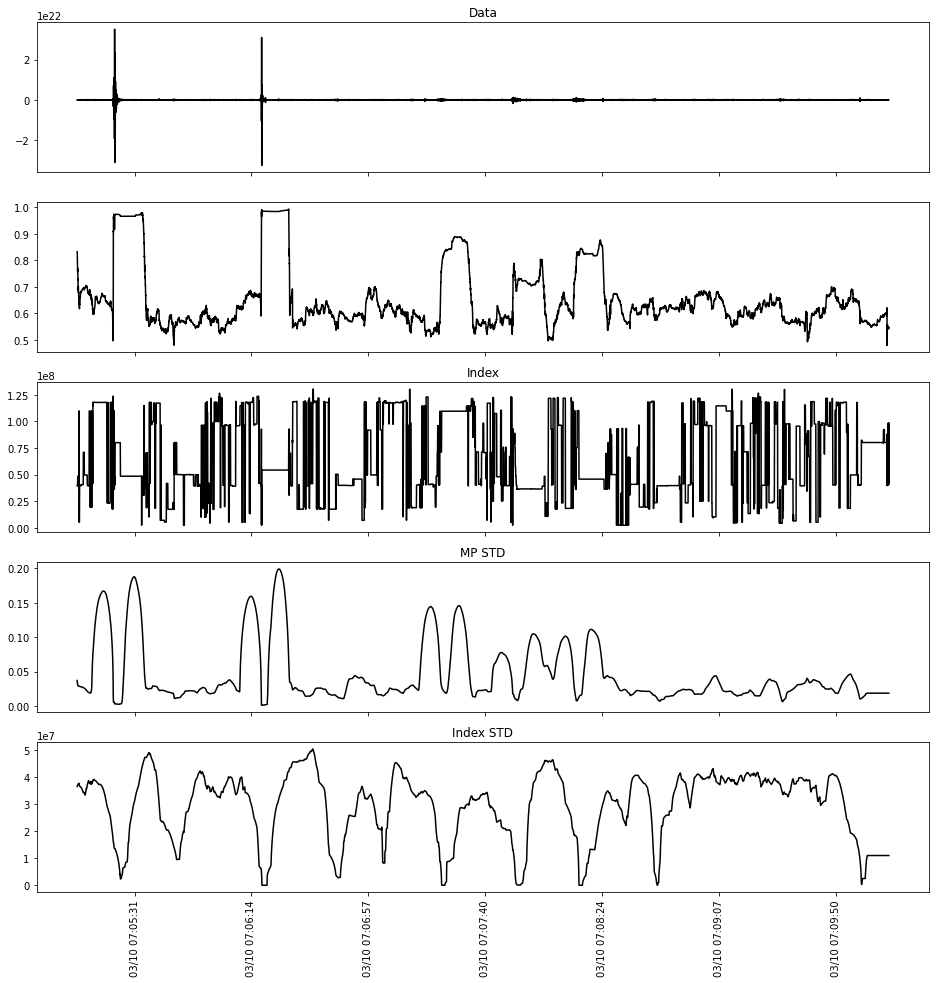

In [25]:
# PLOT time window

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

t1 = mdates.date2num(UTCDateTime(2020,3,10,7,5,0)._get_datetime())
t2 = mdates.date2num(UTCDateTime(2020,3,10,7,10,0)._get_datetime())
i1 = np.argmax(tvec>t1)
i2 = np.argmax(tvec>t2)
id1 = (sublen_samp - 1) + i1
id2 = (sublen_samp - 1) + i2
print(i1, i2, i2-i1)



def RunningStd(x,N):
    idx = np.arange(N) + np.arange(len(x)-N+1)[:,None]
    #b = [row[row>0] for row in x[idx]] # to exclude 0's
    #return np.array(map(np.std,b)) # to exclude 0's
    #return np.std(x[idx],axis=1) # no padding
    return np.pad(np.std(x[idx],axis=1), pad_width=(0, N-1), mode="edge")
    #return np.array([np.median(c) for c in b])  # This also works
    
mp = mpObj.mp[i1:i2]
ind = mpObj.ind[i1:i2]
mpstd = RunningStd(mp, N=400)
indstd = RunningStd(ind, N=400)
print(len(mp), len(mpstd))
print(len(mp), len(mpstd))

fig, axs = plt.subplots(5,1, sharex=True, figsize=(16,16))
axs[0].plot(tvec[id1:id2], trace1.data[id1:id2], "k")
axs[0].set_title("Data")
axs[1].plot(tvec[id1:id2], mpObj.mp[i1:i2], "k")
axs[2].set_title("Matrix Profile")
axs[2].plot(tvec[id1:id2], mpObj.ind[i1:i2], "k")
axs[2].set_title("Index")
axs[3].plot(tvec[id1:id2], mpstd, "k")
axs[3].set_title("MP STD")
axs[4].plot(tvec[id1:id2], indstd, "k")
axs[4].set_title("Index STD")

hfmt = mdates.DateFormatter('%m/%d %H:%M:%S')
#axs[0].xaxis.set_minor_locator(mdates.SecondLocator())
#ax.xaxis.set_major_locator(dates.MinuteLocator())
axs[0].xaxis.set_major_formatter(hfmt)
plt.xticks(rotation='vertical')
plt.show()
plt.close()

In [15]:
def RunningMean(x,N):
    idx = np.arange(N) + np.arange(len(x)-N+1)[:,None]
    return np.pad(np.mean(x[idx],axis=1), pad_width=(0, N-1), mode="edge")

x = np.array([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])
out=RunningMean(x, N=3)
print(len(x), len(out))
print(out)

12 12
[ 1.          1.          1.33333333  1.66666667  2.          2.
  2.33333333  2.66666667  3.          3.          3.          3.        ]


In [7]:
# TIME WINDOWS 

pos1 = mpObj.pairs["win_id_1"].values  
pos2 = mpObj.pairs["win_id_2"].values 
pos = np.unique(np.hstack((pos1, pos2)))

for ix in pos:
    tix = mpObj.mp_starttime + ix/mpObj.fs
    print(tix)
    

2020-02-18T00:00:00.500000Z
2020-02-18T00:00:00.504000Z
2020-02-18T00:00:00.508000Z
2020-02-18T00:00:00.512000Z
2020-02-18T00:00:00.516000Z
2020-02-18T00:00:00.520000Z
2020-02-18T00:00:00.524000Z
2020-02-18T00:00:00.528000Z
2020-02-18T00:00:00.532000Z
2020-02-18T00:00:00.536000Z
2020-02-18T00:00:00.540000Z
2020-02-18T00:00:00.544000Z
2020-02-18T00:00:00.548000Z
2020-02-18T00:00:00.552000Z
2020-02-18T00:00:00.556000Z
2020-02-18T00:00:00.560000Z
2020-02-18T00:00:00.564000Z
2020-02-18T00:00:00.568000Z
2020-02-18T00:00:00.572000Z
2020-02-18T00:00:00.576000Z
2020-02-18T00:00:00.580000Z
2020-02-18T00:00:00.584000Z
2020-02-18T00:00:00.588000Z
2020-02-18T00:00:00.592000Z
2020-02-18T00:00:00.596000Z
2020-02-18T00:00:00.600000Z
2020-02-18T00:00:00.604000Z
2020-02-18T00:00:00.608000Z
2020-02-18T00:00:00.612000Z
2020-02-18T00:00:00.616000Z
2020-02-18T00:00:00.620000Z
2020-02-18T00:00:00.624000Z
2020-02-18T00:00:00.628000Z
2020-02-18T00:00:00.632000Z
2020-02-18T00:00:00.636000Z
2020-02-18T00:00:00.

2020-02-18T00:00:08.988000Z
2020-02-18T00:00:08.992000Z
2020-02-18T00:00:08.996000Z
2020-02-18T00:00:09.000000Z
2020-02-18T00:00:09.004000Z
2020-02-18T00:00:09.008000Z
2020-02-18T00:00:09.012000Z
2020-02-18T00:00:09.016000Z
2020-02-18T00:00:09.020000Z
2020-02-18T00:00:09.024000Z
2020-02-18T00:00:09.028000Z
2020-02-18T00:00:09.032000Z
2020-02-18T00:00:09.036000Z
2020-02-18T00:00:09.040000Z
2020-02-18T00:00:09.044000Z
2020-02-18T00:00:09.048000Z
2020-02-18T00:00:09.052000Z
2020-02-18T00:00:09.056000Z
2020-02-18T00:00:09.060000Z
2020-02-18T00:00:09.064000Z
2020-02-18T00:00:09.068000Z
2020-02-18T00:00:09.072000Z
2020-02-18T00:00:09.076000Z
2020-02-18T00:00:09.080000Z
2020-02-18T00:00:09.084000Z
2020-02-18T00:00:09.088000Z
2020-02-18T00:00:09.092000Z
2020-02-18T00:00:09.096000Z
2020-02-18T00:00:09.100000Z
2020-02-18T00:00:09.104000Z
2020-02-18T00:00:09.108000Z
2020-02-18T00:00:09.112000Z
2020-02-18T00:00:09.116000Z
2020-02-18T00:00:09.120000Z
2020-02-18T00:00:09.124000Z
2020-02-18T00:00:09.

2020-02-18T00:00:17.620000Z
2020-02-18T00:00:17.624000Z
2020-02-18T00:00:17.628000Z
2020-02-18T00:00:17.632000Z
2020-02-18T00:00:17.636000Z
2020-02-18T00:00:17.640000Z
2020-02-18T00:00:17.644000Z
2020-02-18T00:00:17.648000Z
2020-02-18T00:00:17.652000Z
2020-02-18T00:00:17.656000Z
2020-02-18T00:00:17.660000Z
2020-02-18T00:00:17.664000Z
2020-02-18T00:00:17.668000Z
2020-02-18T00:00:17.672000Z
2020-02-18T00:00:17.676000Z
2020-02-18T00:00:17.680000Z
2020-02-18T00:00:17.684000Z
2020-02-18T00:00:17.688000Z
2020-02-18T00:00:17.692000Z
2020-02-18T00:00:17.696000Z
2020-02-18T00:00:17.700000Z
2020-02-18T00:00:17.704000Z
2020-02-18T00:00:17.708000Z
2020-02-18T00:00:17.712000Z
2020-02-18T00:00:17.716000Z
2020-02-18T00:00:17.720000Z
2020-02-18T00:00:17.724000Z
2020-02-18T00:00:17.728000Z
2020-02-18T00:00:17.732000Z
2020-02-18T00:00:17.736000Z
2020-02-18T00:00:17.740000Z


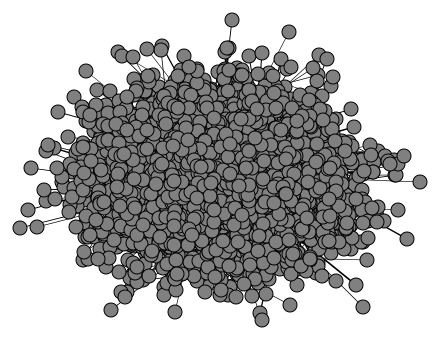

In [15]:
from IPython.display import SVG

import numpy as np
from scipy import sparse

from sknetwork.utils import edgelist2adjacency, edgelist2biadjacency
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph

# Create graph
subset = mpObj.pairs[["win_id_1", "win_id_2", "peak_cc"]]

edgelist = [tuple(x) for x in subset.to_numpy()]
adjacency = edgelist2adjacency(edgelist)

#image = svg_graph(adjacency)
#SVG(image)

In [18]:
# CONNECTED COMPONENTS AND LABELS

from sknetwork.topology import connected_components

labels = connected_components(adjacency)
print(set(labels))

# GROUPS

import networkx as nx
from networkx.algorithms.components import *

G = nx.from_scipy_sparse_matrix(adjacency)

#print(is_connected(G))
#print(number_connected_components(G))

groups = [G.subgraph(c).copy() for c in nx.connected_components(G)]

for i, group in enumerate(groups):
    print("Group %d: %d nodes." % (i, len(group)))
#    print(is_connected(group))


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}
Group 0: 4200 nodes.
Group 1: 5 nodes.
Group 2: 24 nodes.
Group 3: 23 nodes.
Group 4: 9 nodes.
Group 5: 6 nodes.
Group 6: 2 nodes.
Group 7: 2 nodes.
Group 8: 5 nodes.
Group 9: 7 nodes.
Group 10: 2 nodes.
Group 11: 2 nodes.
Group 12: 2 nodes.
Group 13: 5 nodes.
Group 14: 2 nodes.
Group 15: 2 nodes.
Group 16: 2 nodes.
Group 17: 3 nodes.
Group 18: 2 nodes.
Group 19: 2 nodes.
Group 20: 2 nodes.
Group 21: 2 nodes.


group 0
4200
0.855436058837


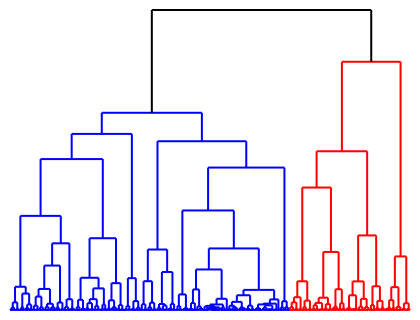

In [24]:
from sknetwork.hierarchy import Paris, BiParis, cut_straight, dasgupta_score, tree_sampling_divergence
from sknetwork.visualization import svg_dendrogram
%matplotlib inline

i = 0
group = groups[i]
print("group %d" % i)
group = groups[i]
print(len(group))
tmp = nx.to_scipy_sparse_matrix(group)
paris = Paris()
dendrogram = paris.fit_transform(tmp)
score = tree_sampling_divergence(tmp, dendrogram, normalized=True)
print(score)
image = svg_dendrogram(dendrogram)
SVG(image)

group 2
24
0.730401065003


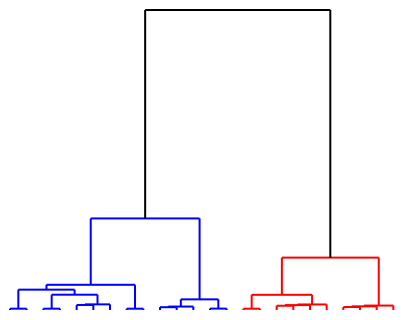

In [28]:
i = 2
group = groups[i]
print("group %d" % i)
group = groups[i]
print(len(group))
tmp = nx.to_scipy_sparse_matrix(group)
paris = Paris()
dendrogram = paris.fit_transform(tmp)
score = tree_sampling_divergence(tmp, dendrogram, normalized=True)
print(score)
image = svg_dendrogram(dendrogram)
SVG(image)

# Cut tree
labels = cut_straight(dendrogram, n_clusters = 4)
print(labels)